# Обучение и сравнение моделей машинного обучения

На данном этапе производится обучение и сравнение различных алгоритмов машинного обучения для классификации писем на легитимные и фишинговые. Для каждого алгоритма выполняется подбор гиперпараметров, кросс-валидация и оценка на валидационной выборке. Затем выбирается лучшая модель, выполняется калибровка весов агрегации эвристического модуля и ML-модели, и финальная оценка на тестовой выборке.


# 1. Загрузка данных

На данном этапе производится загрузка предобработанных данных
- `train.pkl` — обучающая выборка (X_train, y_train)
- `val.pkl` — валидационная выборка (X_val, y_val)  
- `test.pkl` — тестовая выборка (X_test, y_test)
- `tfidf_vectorizer.pkl` — обученный векторизатор и MinMaxScaler

Данные были предобработаны и сохранены в блокноте `dataset_and_features.ipynb`.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tqdm_joblib

In [3]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import time
import json
import warnings
warnings.filterwarnings('ignore')
import sys

# Импорт библиотек для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from scipy.stats import loguniform, randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

BASE_DIR = (Path('/content/drive/MyDrive') / 'eml-phishing-analyzer').resolve()
DATA_DIR = BASE_DIR / 'data' / 'models'

if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Настройка путей
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'
DATA_DIR = BASE_DIR / 'data' / 'models'


# Настройка визуализации
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [4]:
# Загрузка данных
with open(DATA_DIR / 'train.pkl', 'rb') as f:
    train_data = pickle.load(f)
    X_train = train_data['X_train']
    y_train = train_data['y_train']
    train_indices = train_data.get('train_indices')

with open(DATA_DIR / 'val.pkl', 'rb') as f:
    val_data = pickle.load(f)
    X_val = val_data['X_val']
    y_val = val_data['y_val']
    val_indices = val_data.get('val_indices')

with open(DATA_DIR / 'test.pkl', 'rb') as f:
    test_data = pickle.load(f)
    X_test = test_data['X_test']
    y_test = test_data['y_test']
    test_indices = test_data.get('test_indices')

with open(DATA_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer_data = pickle.load(f)
    tfidf_vectorizer = vectorizer_data['vectorizer']
    synthetic_scaler = vectorizer_data.get('scaler')

print(f"\nРазмерности данных:")
print(f"  Train:      {X_train.shape[0]} образцов, {X_train.shape[1]} признаков")
print(f"  Validation: {X_val.shape[0]} образцов, {X_val.shape[1]} признаков")
print(f"  Test:       {X_test.shape[0]} образцов, {X_test.shape[1]} признаков")
print(f"\nРаспределение классов в train:")
print(f"  Legitimate (0): {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Phishing (1):   {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")


Размерности данных:
  Train:      4161 образцов, 4969 признаков
  Validation: 892 образцов, 4969 признаков
  Test:       892 образцов, 4969 признаков

Распределение классов в train:
  Legitimate (0): 2082 (50.0%)
  Phishing (1):   2079 (50.0%)


# 2. Подбор гиперпараметров и обучение моделей

На данном этапе производится обучение и сравнение пяти различных алгоритмов машинного обучения, применимых к задаче классификации писем на легитимные и фишинговые. Для каждого алгоритма выполняется подбор гиперпараметров с использованием `RandomizedSearchCV` и обучение на обучающей выборке.

Используемые алгоритмы:
- **Logistic Regression** — линейная модель с логистической функцией потерь
- **SVM (Linear Kernel)** — метод опорных векторов с линейным ядром
- **Random Forest** — ансамбль решающих деревьев
- **Naive Bayes** — байесовский классификатор
- **XGBoost** — градиентный бустинг на деревьях решений

Для оценки эффективности моделей используются метрики `accuracy`, `F1-мера`, `precision`, `recall`, а также замеряется время обучения каждой модели.


## 2.1 Logistic Regression


In [38]:
# Logistic Regression
print("=" * 60)
print("Обучение Logistic Regression...")
print("=" * 60)

lr_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)

# Параметры для RandomizedSearchCV
lr_param_dist = {
    'C': loguniform(1e-4, 1e3),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

lr_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_dist,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

total_fits = lr_random_search.n_iter * lr_random_search.cv

print("Подбор гиперпараметров...")
start_time = time.time()

with tqdm_joblib(tqdm(total=total_fits, desc="Итерации кросс-валидации (CV)")):
    lr_random_search.fit(X_train, y_train)

lr_fit_time = time.time() - start_time

print(f"\nОбучение завершено за {lr_fit_time:.2f} секунд")
print(f"Лучшие параметры: {lr_random_search.best_params_}")
print(f"Лучший F1-score (CV): {lr_random_search.best_score_:.4f}")

best_lr = lr_random_search.best_estimator_


Обучение Logistic Regression...
Подбор гиперпараметров...


Итерации кросс-валидации (CV):   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]


Обучение завершено за 54.58 секунд
Лучшие параметры: {'C': np.float64(655.0713895392056), 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Лучший F1-score (CV): 0.9823


## 2.2 SVM (Linear Kernel)


In [54]:
# SVM (Linear Kernel)
print("=" * 60)
print("Обучение SVM (Linear Kernel)...")
print("=" * 60)

svm_model = SVC(kernel='linear', random_state=42, probability=True)

# Параметры для RandomizedSearchCV
svm_param_dist = {
    'C': loguniform(1e-1, 1e1),
    'max_iter': [1000, 2000],
    'class_weight': [None, 'balanced']
}

svm_random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=svm_param_dist,
    n_iter=10,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Подбор гиперпараметров...")
with tqdm(total=15, desc="  Кандидаты") as pbar:
    start_time = time.time()
    svm_random_search.fit(X_train, y_train)
    svm_fit_time = time.time() - start_time
    pbar.update(15)

print(f"\n Обучение завершено за {svm_fit_time:.2f} секунд")
print(f"Лучшие параметры: {svm_random_search.best_params_}")
print(f"Лучший F1-score (CV): {svm_random_search.best_score_:.4f}")

best_svm = svm_random_search.best_estimator_


Обучение SVM (Linear Kernel)...
Подбор гиперпараметров...


  Кандидаты:   0%|          | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Обучение завершено за 138.34 секунд
Лучшие параметры: {'C': np.float64(0.7309539835912913), 'class_weight': None, 'max_iter': 1000}
Лучший F1-score (CV): 0.9812


## 2.3 Random Forest


In [7]:
# Random Forest
print("=" * 60)
print("Обучение Random Forest...")
print("=" * 60)

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Параметры для RandomizedSearchCV
rf_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'class_weight': [None, 'balanced']
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Подбор гиперпараметров...")
with tqdm(total=20, desc="  Кандидаты") as pbar:
    start_time = time.time()
    rf_random_search.fit(X_train, y_train)
    rf_fit_time = time.time() - start_time
    pbar.update(20)

print(f"\nОбучение завершено за {rf_fit_time:.2f} секунд")
print(f"Лучшие параметры: {rf_random_search.best_params_}")
print(f"Лучший F1-score (CV): {rf_random_search.best_score_:.4f}")

best_rf = rf_random_search.best_estimator_


Обучение Random Forest...
Подбор гиперпараметров...


  Кандидаты:   0%|          | 0/20 [00:00<?, ?it/s]


Обучение завершено за 55.59 секунд
Лучшие параметры: {'class_weight': None, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Лучший F1-score (CV): 0.9816


## 2.4 Naive Bayes


In [8]:
# Naive Bayes
print("=" * 60)
print("Обучение Naive Bayes...")
print("=" * 60)

nb_model = MultinomialNB()

# Параметры для RandomizedSearchCV
nb_param_dist = {
    'alpha': uniform(0.1, 2.0)
}

nb_random_search = RandomizedSearchCV(
    estimator=nb_model,
    param_distributions=nb_param_dist,
    n_iter=15,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Подбор гиперпараметров...")
with tqdm(total=15, desc="  Кандидаты") as pbar:
    start_time = time.time()
    nb_random_search.fit(X_train, y_train)
    nb_fit_time = time.time() - start_time
    pbar.update(15)

print(f"\nОбучение завершено за {nb_fit_time:.2f} секунд")
print(f"Лучшие параметры: {nb_random_search.best_params_}")
print(f"Лучший F1-score (CV): {nb_random_search.best_score_:.4f}")

best_nb = nb_random_search.best_estimator_


Обучение Naive Bayes...
Подбор гиперпараметров...


  Кандидаты:   0%|          | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Обучение завершено за 0.26 секунд
Лучшие параметры: {'alpha': np.float64(0.21616722433639893)}
Лучший F1-score (CV): 0.9781


## 2.5 XGBoost


In [9]:
# XGBoost
print("=" * 60)
print("Обучение XGBoost...")
print("=" * 60)

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1, early_stopping_rounds=10)

# Параметры для RandomizedSearchCV
xgb_param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 300),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Подбор гиперпараметров...")
with tqdm(total=20, desc="  Кандидаты") as pbar:
    start_time = time.time()
    xgb_random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    xgb_fit_time = time.time() - start_time
    pbar.update(20)

print(f"\nОбучение завершено за {xgb_fit_time:.2f} секунд")
print(f"Лучшие параметры: {xgb_random_search.best_params_}")
print(f"Лучший F1-score (CV): {xgb_random_search.best_score_:.4f}")

best_xgb = xgb_random_search.best_estimator_


Обучение XGBoost...
Подбор гиперпараметров...


  Кандидаты:   0%|          | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Обучение завершено за 489.47 секунд
Лучшие параметры: {'colsample_bytree': np.float64(0.6053059844639466), 'learning_rate': np.float64(0.29266052670545584), 'max_depth': 8, 'n_estimators': 291, 'subsample': np.float64(0.7541666010159664)}
Лучший F1-score (CV): 0.9806


# 3. Кросс-валидация

Для каждой модели выполняется 5-кратная стратифицированная кросс-валидация на обучающей выборке. Это позволяет оценить стабильность и обобщающую способность моделей, а также получить усредненные метрики с оценкой стандартного отклонения для анализа вариативности результатов.


In [55]:
# Словарь всех моделей
models_dict = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Random Forest': best_rf,
    'Naive Bayes': best_nb,
    'XGBoost': best_xgb
}

if 'XGBoost' in models_dict and hasattr(models_dict['XGBoost'], 'early_stopping_rounds'):
    if models_dict['XGBoost'].early_stopping_rounds is not None:
        print("Отключение early_stopping_rounds для XGBoost в кросс-валидации.")
        models_dict['XGBoost'].set_params(early_stopping_rounds=None)


# Метрики для кросс-валидации
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Выполнение кросс-валидации для всех моделей
cv_results_all = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Выполнение 5-кратной кросс-валидации...")
print("=" * 60)

for name, model in tqdm(models_dict.items(), desc="Модели"):
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring_metrics,
        return_train_score=False,
        n_jobs=-1
    )

    cv_results_all[name] = {
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_mean': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'recall_mean': cv_results['test_recall'].mean(),
        'recall_std': cv_results['test_recall'].std(),
        'f1_mean': cv_results['test_f1'].mean(),
        'f1_std': cv_results['test_f1'].std()
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {cv_results_all[name]['accuracy_mean']:.4f} \u00b1 {cv_results_all[name]['accuracy_std']:.4f}")
    print(f"  Precision: {cv_results_all[name]['precision_mean']:.4f} \u00b1 {cv_results_all[name]['precision_std']:.4f}")
    print(f"  Recall: {cv_results_all[name]['recall_mean']:.4f} \u00b1 {cv_results_all[name]['recall_std']:.4f}")
    print(f"  F1-score: {cv_results_all[name]['f1_mean']:.4f} \u00b1 {cv_results_all[name]['f1_std']:.4f}")

print("\n Кросс-валидация завершена")


Выполнение 5-кратной кросс-валидации...


Модели:   0%|          | 0/5 [00:00<?, ?it/s]


Logistic Regression:
  Accuracy: 0.9820 ± 0.0030
  Precision: 0.9781 ± 0.0058
  Recall: 0.9861 ± 0.0035
  F1-score: 0.9820 ± 0.0030

SVM:
  Accuracy: 0.9803 ± 0.0026
  Precision: 0.9826 ± 0.0059
  Recall: 0.9779 ± 0.0028
  F1-score: 0.9802 ± 0.0026

Random Forest:
  Accuracy: 0.9769 ± 0.0080
  Precision: 0.9698 ± 0.0125
  Recall: 0.9846 ± 0.0072
  F1-score: 0.9771 ± 0.0078

Naive Bayes:
  Accuracy: 0.9786 ± 0.0030
  Precision: 0.9721 ± 0.0092
  Recall: 0.9856 ± 0.0068
  F1-score: 0.9788 ± 0.0029

XGBoost:
  Accuracy: 0.9786 ± 0.0087
  Precision: 0.9739 ± 0.0085
  Recall: 0.9837 ± 0.0137
  F1-score: 0.9787 ± 0.0088

 Кросс-валидация завершена


# 4. Оценка на валидационной выборке

Для каждой модели выполняется предсказание на валидационной выборке и расчет метрик качества: Accuracy, Precision, Recall, F1-score. Дополнительно измеряется время инференса для оценки производительности моделей.


In [56]:
# Оценка на валидационной выборке
val_results = []

print("Оценка моделей на валидационной выборке...")
print("=" * 60)

for name, model in models_dict.items():
    # Предсказание
    start_time = time.time()
    y_pred = model.predict(X_val)
    inference_time = (time.time() - start_time) / X_val.shape[0] * 1000

    # Метрики
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, 'decision_function'):
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        y_score = scaler.fit_transform(model.decision_function(X_val).reshape(-1, 1))

    val_results.append({
        'Модель': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Inference time (ms)': inference_time
    })

    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:   {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Inference: {inference_time:.4f} ms/образец")

val_results_df = pd.DataFrame(val_results)
print("\n" + "=" * 60)
print("Сводная таблица результатов на валидационной выборке:")
print("=" * 60)
display(val_results_df)

Оценка моделей на валидационной выборке...

Logistic Regression:
  Accuracy:  0.9832
  Precision: 0.9757
  Recall:   0.9910
  F1-score:  0.9833
  Inference: 0.0011 ms/образец

SVM:
  Accuracy:  0.9843
  Precision: 0.9865
  Recall:   0.9821
  F1-score:  0.9843
  Inference: 0.2926 ms/образец

Random Forest:
  Accuracy:  0.9776
  Precision: 0.9712
  Recall:   0.9843
  F1-score:  0.9777
  Inference: 0.0399 ms/образец

Naive Bayes:
  Accuracy:  0.9720
  Precision: 0.9647
  Recall:   0.9798
  F1-score:  0.9722
  Inference: 0.0010 ms/образец

XGBoost:
  Accuracy:  0.9843
  Precision: 0.9758
  Recall:   0.9933
  F1-score:  0.9844
  Inference: 0.0163 ms/образец

Сводная таблица результатов на валидационной выборке:


,Модель,Accuracy,Precision,Recall,F1-score,Inference time (ms)
0,Logistic Regression,0.983184,0.975717,0.991031,0.983315,0.001106
1,SVM,0.984305,0.986486,0.982063,0.984270,0.292594
2,Random Forest,0.977578,0.971239,0.984305,0.977728,0.039927
3,Naive Bayes,0.971973,0.964680,0.979821,0.972191,0.000991
4,XGBoost,0.984305,0.975771,0.993274,0.984444,0.016343


## 4.1 Матрицы ошибок на валидационной выборке

Матрицы ошибок позволяют визуально оценить качество классификации каждой модели и проанализировать распределение ошибок между классами.


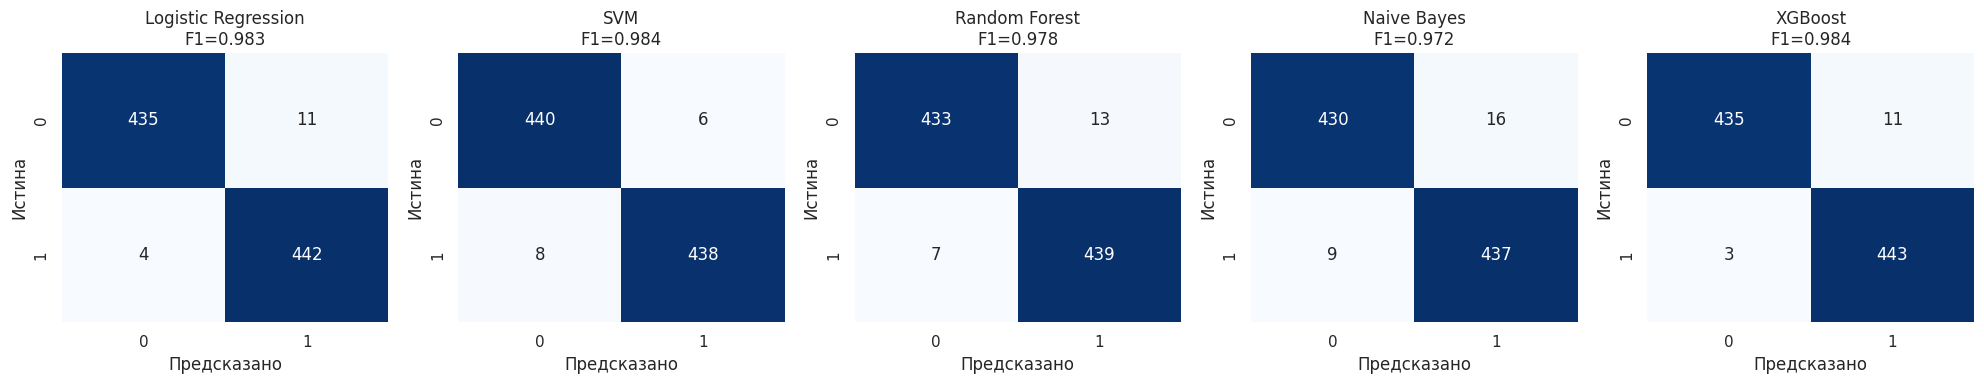

In [49]:
# Матрицы ошибок для всех моделей
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (name, model) in enumerate(models_dict.items()):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar=False
    )
    axes[idx].set_title(f'{name}\nF1={f1_score(y_val, y_pred):.3f}')
    axes[idx].set_xlabel('Предсказано')
    axes[idx].set_ylabel('Истина')

plt.tight_layout()
plt.show()


# 5. Калибровка весов агрегации для всех моделей

Для каждого алгоритма выполняется подбор оптимальных весов агрегации с эвристическим модулем. Используется grid search для поиска комбинации весов, обеспечивающей максимальный F1-score на валидационной выборке.


In [13]:
!pip install urlextract tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.9 MB/s eta 0:00:00


In [14]:
from src.email_parser import parse_email
from src.header_analyzer import analyze_headers
from src.rules_engine import evaluate_all_rules
from src.threat_intelligence import ThreatIntelligence
from sklearn.preprocessing import MinMaxScaler

ti = ThreatIntelligence(BASE_DIR / 'data' / 'threat_intelligence' / 'ti_test_real_feeds.db')

def compute_risk_score(email_content: str) -> int:
    try:
        parsed = parse_email(email_content)
        header_analysis = analyze_headers(parsed)
        ti_results = ti.check_reputation(parsed.get('domains', []), parsed.get('ips', []))
        return evaluate_all_rules(header_analysis, parsed, ti_results)['risk_score']
    except:
        return 0

print("Модули загружены")

Модули загружены


## 5.1 Вычисление risk_score для валидационной выборки

In [42]:
email_df = pd.read_csv(BASE_DIR / 'data' / 'processed' / 'email_dataset.csv')

risk_scores_val = np.array([
    compute_risk_score(email_df.iloc[idx]['email_content']) if idx < len(email_df) else 0
    for idx in tqdm(val_indices, desc=" Обработка")
])

risk_scores_val_normalized = risk_scores_val / 100.0
print(f"Загружено {len(email_df)} записей, средний risk_score на валидационной выборке: {risk_scores_val.mean():.2f}")

 Обработка:   0%|          | 0/892 [00:00<?, ?it/s]

Загружено 5945 записей, средний risk_score на валидационной выборке: 15.22


## 5.2 Калибировка весов агрегации

In [44]:
def calibrate_weights(model, X_val, y_val, risk_scores_normalized):
    """Калибровка весов агрегации для модели"""

    decision_scaler = None
    confidence = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') \
                 else MinMaxScaler().fit_transform(model.decision_function(X_val).reshape(-1, 1)).ravel()

    if not hasattr(model, 'predict_proba'):
        decision_scaler = MinMaxScaler()
        confidence = decision_scaler.fit_transform(model.decision_function(X_val).reshape(-1, 1)).ravel()

    best_f1, best_recall = 0, 0
    best_config = None

    for w_rules in np.arange(0.1, 0.5, 0.05):
        w_ml = 1.0 - w_rules
        final_scores = w_rules * risk_scores_normalized + w_ml * confidence

        for threshold in np.arange(0.1, 1.0, 0.05):
            y_pred = (final_scores >= threshold).astype(int)
            f1, recall = f1_score(y_val, y_pred), recall_score(y_val, y_pred)

            if f1 > best_f1 or (abs(f1 - best_f1) < 0.0001 and recall > best_recall):
                best_f1, best_recall = f1, recall
                best_config = {
                    'w_rules': w_rules, 'w_ml': w_ml, 'threshold': threshold,
                    'final_scores': final_scores.copy()
                }

    y_pred_final = (best_config['final_scores'] >= best_config['threshold']).astype(int)

    return {
        **best_config,
        'accuracy': accuracy_score(y_val, y_pred_final),
        'precision': precision_score(y_val, y_pred_final, zero_division=0),
        'recall': recall_score(y_val, y_pred_final),
        'f1': f1_score(y_val, y_pred_final),
        'y_pred': y_pred_final,
        'decision_scaler': decision_scaler
    }

In [50]:
print("=" * 60)
print("Калибровка весов для всех моделей...")
print("=" * 60)

calibration_results = {}

for name, model in tqdm(models_dict.items(), desc="Модели"):
    result = calibrate_weights(model, X_val, y_val, risk_scores_val_normalized)
    calibration_results[name] = result

    print(f"\n{name}:")
    print(f"  w_rules={result['w_rules']:.2f}, w_ml={result['w_ml']:.2f}, threshold={result['threshold']:.2f}")
    print(f"  F1={result['f1']:.4f}, Recall={result['recall']:.4f}")

Калибровка весов для всех моделей...


Модели:   0%|          | 0/5 [00:00<?, ?it/s]


Logistic Regression:
  w_rules=0.30, w_ml=0.70, threshold=0.50
  F1=0.9866, Recall=0.9910

SVM:
  w_rules=0.25, w_ml=0.75, threshold=0.40
  F1=0.9877, Recall=0.9888

Random Forest:
  w_rules=0.45, w_ml=0.55, threshold=0.30
  F1=0.9833, Recall=0.9888

Naive Bayes:
  w_rules=0.45, w_ml=0.55, threshold=0.40
  F1=0.9865, Recall=0.9821

XGBoost:
  w_rules=0.15, w_ml=0.85, threshold=0.50
  F1=0.9855, Recall=0.9888


In [65]:
import time

# Формирование сравнительной таблицы
comparison_df = pd.DataFrame([
    {
        'Модель': f"{name} + Rules",
        'w_rules': r['w_rules'],
        'w_ml': r['w_ml'],
        'threshold': r['threshold'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-score': r['f1']
    }
    for name, r in calibration_results.items()
]).round(3).sort_values(['Recall', 'F1-score'], ascending=[False, False])

print("Сравнение гибридных систем на validation:")
display(comparison_df)

Сравнение гибридных систем на validation:


,Модель,w_rules,w_ml,threshold,Accuracy,Precision,Recall,F1-score
0,Logistic Regression + Rules,0.30,0.70,0.5,0.987,0.982,0.991,0.987
1,SVM + Rules,0.25,0.75,0.4,0.988,0.987,0.989,0.988
4,XGBoost + Rules,0.15,0.85,0.5,0.985,0.982,0.989,0.985
2,Random Forest + Rules,0.45,0.55,0.3,0.983,0.978,0.989,0.983
3,Naive Bayes + Rules,0.45,0.55,0.4,0.987,0.991,0.982,0.986


# 6. Выбор лучшей модели

**Logistic Regression + Rules** была выбрана как наилучшая модель исходя из приоритетов задачи обнаружения фишинговых писем.

Ключевым критерием является **полнота (Recall)**, так как пропуск вредоносного письма (False Negative) для систем информационной безопасности является наиболее критичным сценарием. Logistic Regression демонстрирует **максимальные значения Recall** среди рассмотренных моделей, при этом сохраняет **высокое качество по F1-мере** (на уровне лучших альтернатив), что указывает на сбалансированность качества детектирования.

Дополнительным фактором является эксплуатационная пригодность модели: Logistic Regression обеспечивает **минимальное время инференса**, что важно для обработки потока писем и последующей масштабируемости решения. С учётом того, что в финальной системе модель применяется совместно с эвристическим модулем, итоговая конфигурация **Logistic Regression + Rules** обеспечивает требуемое сочетание: высокая полнота детектирования при минимальной вычислительной нагрузке и возможности дальнейшей интерпретации результатов.


In [58]:
best_model_name = "Logistic Regression"
best_model = models_dict[best_model_name]
best_result = calibration_results[best_model_name]

print("=" * 60)
print(f"Лучшая гибридная система: {best_model_name} + Rules")
print("=" * 60)
print(f"w_rules={best_result['w_rules']:.2f}, w_ml={best_result['w_ml']:.2f}, threshold={best_result['threshold']:.2f}")
print(f"Accuracy={best_result['accuracy']:.4f}, Precision={best_result['precision']:.4f}")
print(f"Recall={best_result['recall']:.4f}, F1-score={best_result['f1']:.4f}")

Лучшая гибридная система: Logistic Regression + Rules
w_rules=0.30, w_ml=0.70, threshold=0.50
Accuracy=0.9865, Precision=0.9822
Recall=0.9910, F1-score=0.9866


## 6.1 Сохранение лучшей модели и весов


In [66]:
with open(DATA_DIR / 'logreg.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open(DATA_DIR / 'optimal_weights.json', 'w', encoding='utf-8') as f:
    json.dump({
        'model_name': best_model_name,
        'w_ml': float(best_result['w_ml']),
        'w_rules': float(best_result['w_rules']),
        'threshold': float(best_result['threshold'])
    }, f, indent=2, ensure_ascii=False)

print("Модель и веса сохранены")

Модель и веса сохранены


# 7. Визуализация результатов калибровки

Матрицы ошибок для всех гибридных систем и график зависимости F1-score от весов


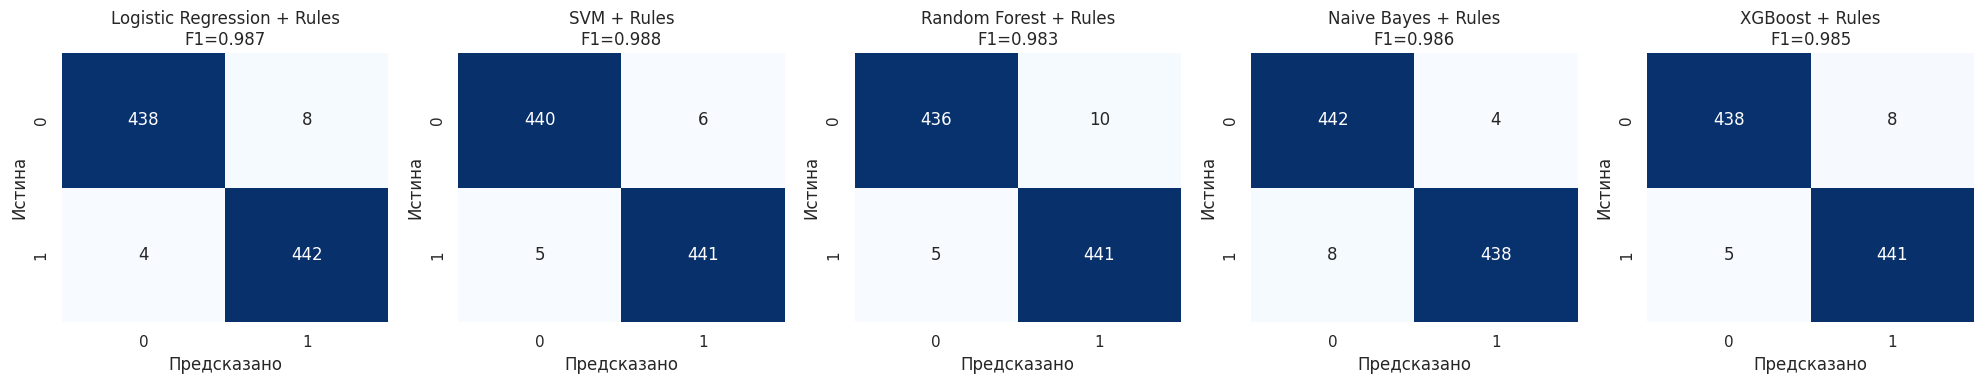

In [68]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (name, result) in enumerate(calibration_results.items()):
    cm = confusion_matrix(y_val, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name} + Rules\nF1={result["f1"]:.3f}')
    axes[idx].set_xlabel('Предсказано')
    axes[idx].set_ylabel('Истина')

plt.tight_layout()
plt.show()

# 8. Оценка на тестовой выборке

Финальная оценка лучшей гибридной системы на тестовой выборке с использованием найденных оптимальных весов.

In [29]:
print("Вычисление risk_score для тестовой выборки...")
risk_scores_test = np.array([
    compute_risk_score(email_df.iloc[idx]['email_content']) if idx < len(email_df) else 0
    for idx in tqdm(test_indices, desc=" Обработка")
])
risk_scores_test_normalized = risk_scores_test / 100.0

Вычисление risk_score для тестовой выборки...


 Обработка:   0%|          | 0/892 [00:00<?, ?it/s]

In [69]:
confidence_test = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') \
                  else MinMaxScaler().fit_transform(best_model.decision_function(X_test).reshape(-1, 1)).ravel()

final_scores_test = best_result['w_rules'] * risk_scores_test_normalized + best_result['w_ml'] * confidence_test
y_pred_test = (final_scores_test >= best_result['threshold']).astype(int)

print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_test):.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm_test.ravel()
print(f"\nМатрица ошибок: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Результаты на тестовой выборке:
Accuracy:  0.9899
Precision: 0.9910
Recall:    0.9888
F1-score:  0.9899

Матрица ошибок: TN=443, FP=4, FN=5, TP=440


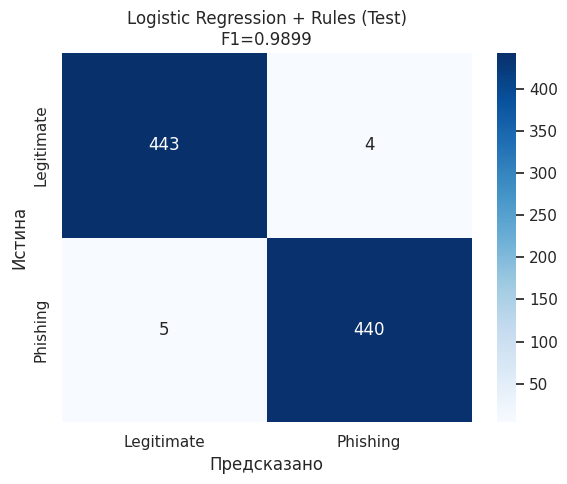

In [70]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title(f'{best_model_name} + Rules (Test)\nF1={f1_score(y_test, y_pred_test):.4f}')
plt.xlabel('Предсказано')
plt.ylabel('Истина')
plt.tight_layout()
plt.show()

In [71]:
# Оценка всех гибридных систем на test
test_results = {}

for name, model in tqdm(models_dict.items(), desc="Оценка на test"):
    result_val = calibration_results[name]

    # Получение confidence для test
    if hasattr(model, 'predict_proba'):
        confidence_test = model.predict_proba(X_test)[:, 1]
    else:
        confidence_test = result_val['decision_scaler'].transform(
            model.decision_function(X_test).reshape(-1, 1)
        ).ravel()

    # Агрегация с весами, найденными на validation
    final_scores = result_val['w_rules'] * risk_scores_test_normalized + result_val['w_ml'] * confidence_test
    y_pred = (final_scores >= result_val['threshold']).astype(int)

    test_results[name] = {
        'w_rules': result_val['w_rules'],
        'w_ml': result_val['w_ml'],
        'threshold': result_val['threshold'],
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'y_pred': y_pred
    }

print("Оценка завершена")

Оценка на test:   0%|          | 0/5 [00:00<?, ?it/s]

Оценка завершена


In [72]:
# Сравнительная таблица на test
test_comparison_df = pd.DataFrame([
    {
        'Модель': f"{name} + Rules",
        'Val F1': calibration_results[name]['f1'],
        'Test Accuracy': r['accuracy'],
        'Test Precision': r['precision'],
        'Test Recall': r['recall'],
        'Test F1': r['f1']
    }
    for name, r in test_results.items()
]).sort_values('Test F1', ascending=False)

print("Результаты гибридных систем на тестовой выборке:")
display(test_comparison_df)

Результаты гибридных систем на тестовой выборке:


,Модель,Val F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Logistic Regression + Rules,0.986607,0.989910,0.990991,0.988764,0.989876
1,SVM + Rules,0.987682,0.984305,0.984270,0.984270,0.984270
3,Naive Bayes + Rules,0.986486,0.984305,0.990888,0.977528,0.984163
2,Random Forest + Rules,0.983278,0.979821,0.977629,0.982022,0.979821
4,XGBoost + Rules,0.985475,0.977578,0.979684,0.975281,0.977477


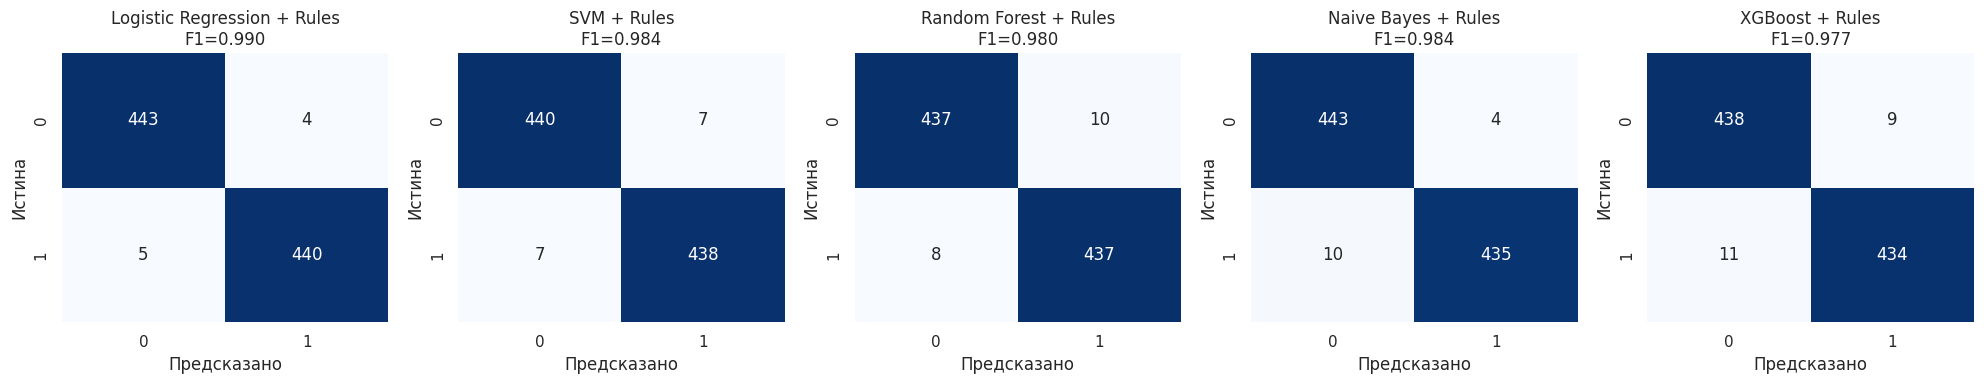

In [74]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (name, result) in enumerate(test_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name} + Rules\nF1={result["f1"]:.3f}')
    axes[idx].set_xlabel('Предсказано')
    axes[idx].set_ylabel('Истина')

plt.tight_layout()
plt.show()